In [21]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3, linewidth=100)
sns.set()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
file_path = '/content/drive/MyDrive/Colab Notebooks/House_Pric_Prediction/housing.csv'

In [16]:
housing = pd.read_csv(file_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.325,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.301,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.257,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.643,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.846,342200.0,NEAR BAY


In [17]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 📥 1. Missing Value Imputation

```python
SimpleImputer(strategy='median')
```

* **What is it?** A technique to fill missing data.
* **Why we use it:** Ensures the model doesn't crash due to `NaN` values. Median is preferred when outliers may distort the mean.

In [22]:
# 🧼 Handle Missing Values
imputer = SimpleImputer(strategy='median')
housing['total_bedrooms'] = imputer.fit_transform(housing[['total_bedrooms']])

## 🔁 2. One-Hot Encoding (Categorical to Numerical)

```python
pd.get_dummies(..., drop_first=True)
```

* **What is it?** Converts text categories into numeric binary columns.
* **Why we use it:** Machine learning models can't process text directly. Encoding enables models to interpret the `ocean_proximity` feature.

In [23]:
# 🔄 Encode Categorical Column
df_encoded = pd.get_dummies(housing, columns=['ocean_proximity'], drop_first=True)


## 🛠️ 3. Feature Engineering

```python
rooms_per_household = total_rooms / households  
bedrooms_per_room = total_bedrooms / total_rooms  
population_per_household = population / households
```

* **What is it?** Creating new, informative features from existing data.
* **Why we use it:** These ratios reveal important relationships that raw features don’t capture directly — improving prediction quality.

In [24]:
# 🛠️ Feature Engineering
df_encoded['rooms_per_household'] = df_encoded['total_rooms'] / df_encoded['households']
df_encoded['bedrooms_per_room'] = df_encoded['total_bedrooms'] / df_encoded['total_rooms']
df_encoded['population_per_household'] = df_encoded['population'] / df_encoded['households']

In [25]:
# 🎯 Separate Features and Target
X = df_encoded.drop('median_house_value', axis=1)
y = df_encoded['median_house_value']

## 📏 4. Feature Scaling

```python
StandardScaler()
```

* **What is it?** Standardizes features to zero mean and unit variance.
* **Why we use it:** Essential for models like **Linear Regression** and **Polynomial Regression** that are sensitive to feature magnitude.


In [26]:
# 📏 Scaling for Linear Models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 🧪 5. Train/Test Split

```python
train_test_split(X, y, test_size=0.2)
```

* **What is it?** Divides the dataset into training and testing portions.
* **Why we use it:** To simulate how the model performs on unseen (real-world) data.

In [27]:
# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 📘 6. Linear Regression

```python
LinearRegression()
```

* **What is it?** A simple algorithm modeling linear relationships.
* **Why we use it:** Great as a baseline model — fast, interpretable, and often surprisingly effective for tabular data.

In [30]:
# 📘 LINEAR REGRESSION
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr) * 100)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)) * 100)

Linear Regression R^2: 59.701768243507615
Linear Regression RMSE: 7266853.837868227


## 🔁 7. Cross-Validation

```python
cross_val_score(..., cv=5)
```

* **What is it?** Splits the dataset into multiple train/test folds for validation.
* **Why we use it:** Prevents misleading results from a single split, improves generalization.

In [31]:
# 🔁 CROSS VALIDATION
cv_scores = cross_val_score(lr, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)
print("Linear Regression Cross-Validated RMSE:", cv_rmse.mean())

Linear Regression Cross-Validated RMSE: 73280.91763794224


## 🌲 8. Random Forest Regressor

```python
RandomForestRegressor()
```

* **What is it?** An ensemble of decision trees that votes for the best outcome.
* **Why we use it:** Robust, non-linear model that handles outliers and doesn't need scaling.

In [33]:
# 🌲 RANDOM FOREST REGRESSOR
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R^2: 0.8071522784479419
Random Forest RMSE: 50270.208449450256


## 📊 Feature Importance (Visualization)

```python
rf.feature_importances_
```

* **What is it?** Tells us which features influenced the model’s decisions the most.
* **Why we use it:** Helps interpret model behavior and focus on impactful features for future improvement.

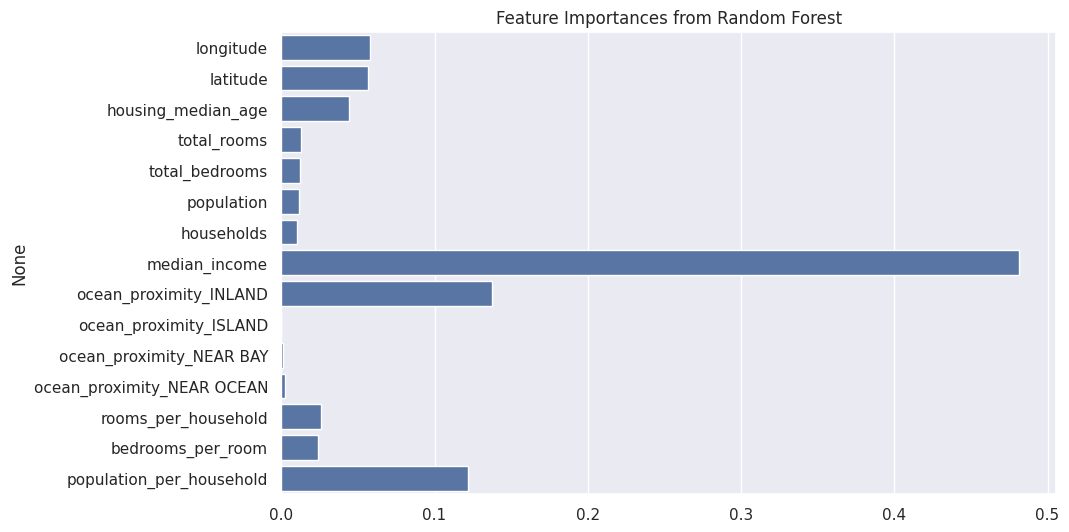

In [34]:
# 🔍 FEATURE IMPORTANCE
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances from Random Forest")
plt.show()

## 🔧 9. Hyperparameter Tuning (GridSearchCV)

```python
GridSearchCV(estimator, param_grid, cv=3)
```

* **What is it?** Tries combinations of model parameters to find the best ones.
* **Why we use it:** Boosts model performance by fine-tuning how the model learns.

In [35]:
# 🔧 HYPERPARAMETER TUNING (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3,
                            scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters (RF):", grid_search.best_params_)

Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## 🌟 10. XGBoost Regressor

```python
XGBRegressor(objective='reg:squarederror')
```

* **What is it?** An advanced gradient boosting algorithm.
* **Why we use it:** Often outperforms other models for structured/tabular data. Great for capturing complex patterns.

In [36]:
# 🌟 XGBOOST REGRESSOR
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost R^2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))


XGBoost R^2: 0.830550636337894
XGBoost RMSE: 47121.96595007798


## 🧠 11. Polynomial Regression

```python
PolynomialFeatures(degree=2)
```

* **What is it?** Transforms data to include powers and interactions of features.
* **Why we use it:** Allows a linear model to capture non-linear relationships, extending its flexibility.

In [37]:
# 🧠 POLYNOMIAL REGRESSION
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train_poly)
y_pred_poly = poly_lr.predict(X_test_poly)

print("Polynomial Regression R^2:", r2_score(y_test_poly, y_pred_poly))
print("Polynomial Regression RMSE:", np.sqrt(mean_squared_error(y_test_poly, y_pred_poly)))

Polynomial Regression R^2: -0.6440901199368805
Polynomial Regression RMSE: 146779.78247028595


## ✅ Summary

| Concept                  | What It Is                              | Why It’s Used                                    |
| ------------------------ | --------------------------------------- | ------------------------------------------------ |
| Missing Value Imputation | Fills empty data                        | Ensures complete data for training               |
| One-Hot Encoding         | Converts categories to binary numbers   | Makes categorical data usable by ML models       |
| Feature Engineering      | Creates new features                    | Captures hidden patterns                         |
| Feature Scaling          | Standardizes feature values             | Needed for linear-based models                   |
| Train/Test Split         | Divides data into training/testing sets | Tests generalization performance                 |
| Linear Regression        | Models linear relationships             | A good, interpretable baseline model             |
| Cross-Validation         | Multiple train/test splits              | Improves result reliability                      |
| Random Forest            | Ensemble of decision trees              | Captures non-linear relationships; robust        |
| GridSearchCV             | Hyperparameter optimization             | Boosts model performance                         |
| XGBoost                  | Boosted tree-based learner              | State-of-the-art performance for structured data |
| Polynomial Regression    | Adds non-linear features                | Extends linear model flexibility                 |
| Feature Importance       | Ranks input features by influence       | Aids interpretability and future engineering     |

# Saving the model

In [39]:
import joblib
joblib.dump(xgb_model, '/content/drive/MyDrive/Colab Notebooks/House_Pric_Prediction/model.pkl')

['/content/drive/MyDrive/Colab Notebooks/House_Pric_Prediction/model.pkl']